<a href="https://colab.research.google.com/github/devikaajay/DSA-Exit-Exam/blob/main/DSA_Exit_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.analyticsvidhya.com/datahack/contest/black-friday/

In [114]:
import os
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


In [115]:
train_zip = os.path.join(".", "train-corrected.zip")
extract_dir = os.path.join(".", "train_extracted")

In [116]:
zip_path = "/mnt/data/train-corrected.zip"
extract_dir = "/mnt/data/train_extracted"

# unzip if not already extracted
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)

# check extracted files
print("Extracted files:", os.listdir(extract_dir))

# ✅ Use the correct extracted CSV filenames
train = pd.read_csv(os.path.join(extract_dir, "/content/train-corrected.zip"))
test = pd.read_csv(os.path.join(extract_dir, "/content/test_Vges7qu.csv"))
sample_sub = pd.read_csv(os.path.join(extract_dir, "/content/test_Vges7qu.csv"))

print("Train:", train.shape, " Test:", test.shape, " Sample:", sample_sub.shape)


Extracted files: []
Train: (550068, 12)  Test: (233599, 12)  Sample: (233599, 12)


In [117]:
#Data cleaning
for col in ["User_ID","Product_ID","Gender","Age","City_Category","Stay_In_Current_City_Years"]:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

for col in ["Product_Category_1","Product_Category_2","Product_Category_3"]:
    train[col] = pd.to_numeric(train[col], errors="coerce")
    test[col] = pd.to_numeric(test[col], errors="coerce")

# Simple derived feature: number of product categories present
train[["Product_Category_2","Product_Category_3"]] = train[["Product_Category_2","Product_Category_3"]].fillna(0)
test[["Product_Category_2","Product_Category_3"]] = test[["Product_Category_2","Product_Category_3"]].fillna(0)

print(train.isnull().sum())

# Drop "Comb" column from test (not needed)
if "Comb" in test.columns:
    test = test.drop(columns=["Comb"])

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64


In [118]:
drop_ids = ["User_ID", "Product_ID"]
X = X.drop(columns=drop_ids)
test = test.drop(columns=drop_ids)
cat_cols = [c for c in X.columns if X[c].dtype=="object"]
num_cols = [c for c in X.columns if c not in cat_cols]

In [120]:
# Preprocessing + Model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In [108]:

# Choose best model available
Model = None
try:
    from lightgbm import LGBMRegressor
    Model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1
    )
    print("Using LightGBM")
except:
    try:
        from xgboost import XGBRegressor
        Model = XGBRegressor(
            n_estimators=1000,
            learning_rate=0.03,
            subsample=0.9,
            colsample_bytree=0.9,
            max_depth=8,
            random_state=42,
            n_jobs=-1,
            tree_method="hist"
        )
        print("Using XGBoost")
    except:
        Model = RandomForestRegressor(
            n_estimators=400,
            n_jobs=-1,
            random_state=42
        )
        print("Using RandomForest")

Using LightGBM


In [121]:
# Transformers
num_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
cat_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

preproc = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols)
    ]
)

pipe = Pipeline(steps=[
    ("prep", preproc),
    ("model", Model)
])

In [128]:
# -------------------------
# 1. Feature engineering
# -------------------------
# Create Num_Product_Cats in train & test
for df in [train, test]:
    df["Num_Product_Cats"] = (
        df[["Product_Category_1", "Product_Category_2", "Product_Category_3"]]
        .gt(0)
        .sum(axis=1)
    )

# -------------------------
# 2. Train preparation
# -------------------------
X_train = train.drop(["User_ID", "Product_ID", "Purchase"], axis=1, errors="ignore")
y_train = train["Purchase"]

# -------------------------
# 3. Fit pipeline
# -------------------------
pipe.fit(X_train, y_train)

# -------------------------
# 4. Test preparation
# -------------------------
X_test = test.drop(["User_ID", "Product_ID"], axis=1, errors="ignore")

# -------------------------
# 5. Predict
# -------------------------
preds = pipe.predict(X_test)

# Clip negatives (just in case)
preds = np.clip(preds, 0, None)

# -------------------------
# 6. Submission
# -------------------------
submission = sample_sub.copy()
submission["Purchase"] = preds

print(test.columns.tolist())  # sanity check
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved!", submission.shape)
print(submission.head())


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 550068, number of used features: 23
[LightGBM] [Info] Start training from score 9263.968713


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Num_Product_Cats']
✅ submission.csv saved! (233599, 13)
               Comb  User_ID Product_ID Gender    Age  Occupation  \
0  1000004P00128942  1000004  P00128942      M  46-50           7   
1  1000009P00113442  1000009  P00113442      M  26-35          17   
2  1000010P00288442  1000010  P00288442      F  36-45           1   
3  1000010P00145342  1000010  P00145342      F  36-45           1   
4  1000011P00053842  1000011  P00053842      F  26-35           1   

  City_Category Stay_In_Current_City_Years  Marital_Status  \
0             B                          2               0   
1             C                          0               0   
2             B                         4+               0   
3             B                         4+               0   
4             C                          1             

   User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase  Num_Product_Cats  
0                 0.0                 0.0      8370                 1  
1                 6.0                14.0     15200           

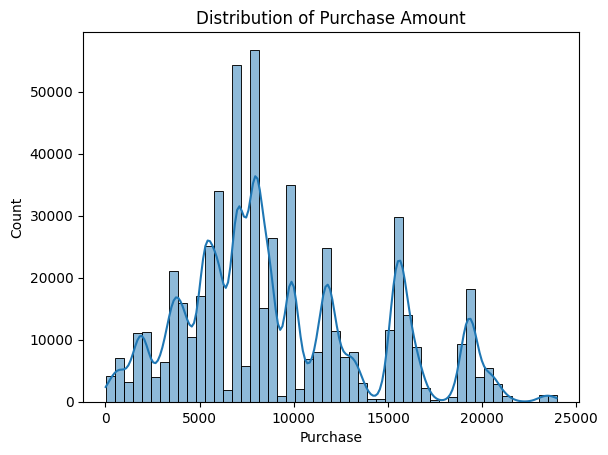

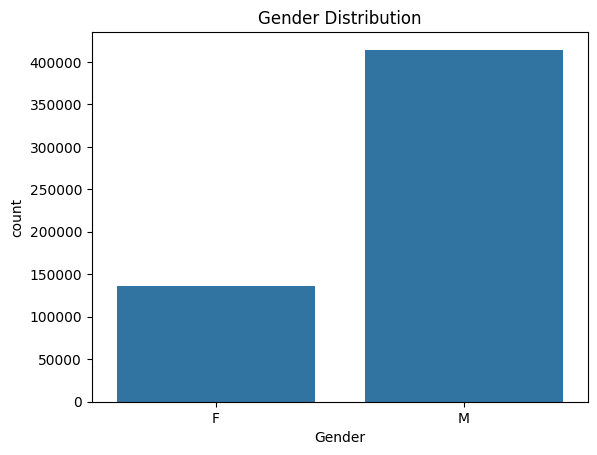

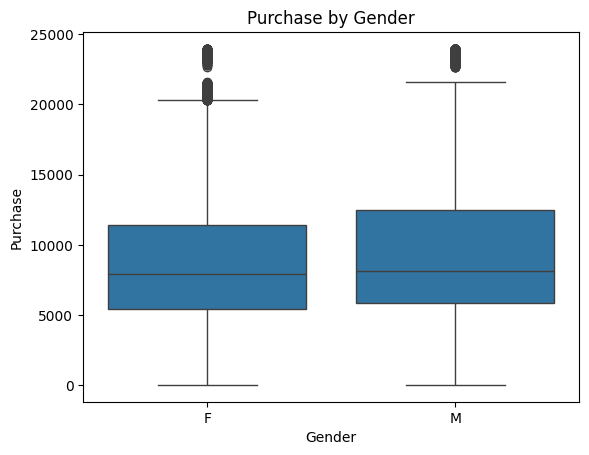

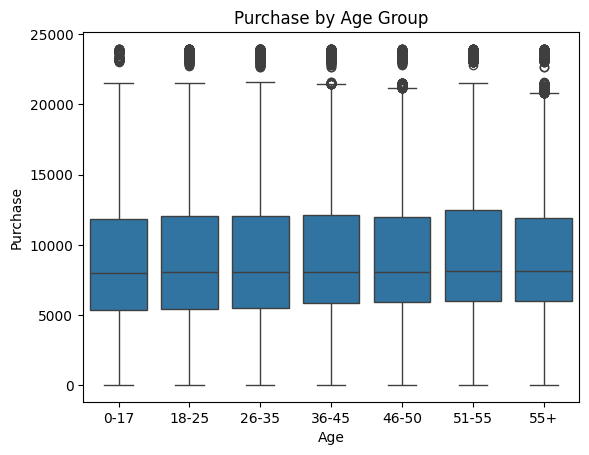

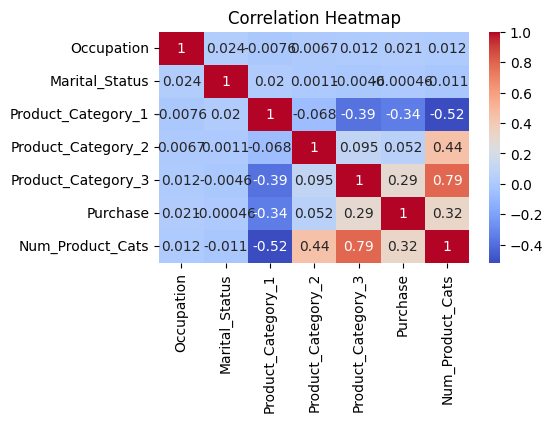

In [129]:
# First look
print(train.head())
print(train.info())
print(train.describe())

# Missing values
print(train.isnull().sum())

# Distribution of target variable
sns.histplot(train["Purchase"], bins=50, kde=True)
plt.title("Distribution of Purchase Amount")
plt.show()

# Gender distribution
sns.countplot(x="Gender", data=train)
plt.title("Gender Distribution")
plt.show()

# Purchase vs Gender
sns.boxplot(x="Gender", y="Purchase", data=train)
plt.title("Purchase by Gender")
plt.show()

# Age vs Purchase
sns.boxplot(x="Age", y="Purchase", data=train)
plt.title("Purchase by Age Group")
plt.show()

# Correlation heatmap (numeric only)
numeric_cols = train.select_dtypes(include="number").columns
plt.figure(figsize=(5,3))
sns.heatmap(train[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [131]:
# Prepare features (drop ID columns and target)
X = train.drop(["Purchase", "User_ID", "Product_ID"], axis=1, errors="ignore")
y = train["Purchase"]

# Identify categorical and numeric features based on dtypes
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

# Preprocessing pipelines for numerical and categorical features
num_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
cat_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols)
    ],
    remainder='passthrough' # Keep other columns (if any) - though none in this case
)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

trained_models = {}
for name, model in models.items():
    # Create a pipeline for each model including preprocessing
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', model)])

    full_pipeline.fit(X_train, y_train)
    trained_models[name] = full_pipeline

In [132]:
# Evaluate each model
for name, model in trained_models.items():
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)   # take square root manually
    print(f"{name} RMSE: {rmse:.2f}")


Linear Regression RMSE: 4602.69
Random Forest RMSE: 3057.29
Gradient Boosting RMSE: 2999.41
